# Bank customer churn prediction: MVP


In this project, the overall goal is to predict the churn of bank customers. From a business perspective, this is very relevant for the effort to retain customers with the ultimate end goal of increasing profitability.

Here in this notebook, a minimal viable product (MVP) is set up to investigate some models and generate a baseline to compare further modeling efforts to.

Customer churn is defined as the percentage of customers that stopped using a company's product or service offering in a defined time frame. One might consider that customer churn is not so important as long as more new customers are acquired than lost to the company. This is fogetting entirely the cost of acquiring new customers. Bringing in new customers is a lot less profitable than retaining customers. In financial services, for example, a 5% increase in customer retention produces more than a 25% increase in profit (http://www2.bain.com/Images/BB_Prescription_cutting_costs.pdf). The reason for that is because returning customers spend on average more than already existing customers. In online services, a loyal customer spends on average 2/3 more than a new one (http://www2.bain.com/Images/Value_online_customer_loyalty_you_capture.pdf). At the same time there is a cost associated with acquiring new customers, which decreases when less new customers have to be acquired. Keeping existing customers thus allows for a reallocation of funds away from the need of growing by acquiring new customers. 

Customer churn can be reduced by pooling resources into keeping the most profitable customers, instead of focusing on keeping overall customer numbers (even unprofitable ones). Another option would be to find out why and when customers are leaving, thus targeting in a customer lifetime this specific point and put effort into avoiding churn. In either case, the customer churn has to be thoroughly analyzed, which is what this small example project is designed to deliver.

## Outline

This churn prediction project follows this outline:

1. Dataset description
2. Descriptive visualizations using Tableau
3. Data extraction, transforming, and loading (ETL)
4. **Analysis of the dataset**
5. Visualization of the insights

In this part of the project, stage 4 is covered. Stages 1 and 2 can be found here: http://heikokromer.com/index.php/2020/01/10/bank-customer-churn-prediction-identifying-the-question/'. 


Stage 3 can be found here: https://kyso.io/heiko/bank-customer-churn-prediction-etl


In [393]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [383]:
class Model():
    """ Class for the Analysis part that contains all the methods"""
    def __init__(self):
        self.save_path_prepared = '../02.Prepared_data/'
        
    def load_data(self, fname):
        """
        Reads and returns the dataset after the ETL process.
        """
        data = pd.read_csv(f"{self.save_path_prepared}/{fname}", index_col=0)
        
        return data
    
    def select_features(self, features, label_col, dataset):
        """
        Selects the columns features (passed as list) from the dataset and returns this dataset. Returns also the labels, 
        the label_col must be passed.
        """
        data_features = dataset[features]
        data_labels = dataset[label_col]

        return data_features, data_labels    
    
    def split_dataset(self, fraction_test, fraction_train, fraction_cv, random_state, X, y):
        """
        Splits the dataset into training, cv, and test set given the fractions.
        """
        if fraction_cv > 0:
            # first split training and (test+cv)
            X_train, X_test_cv, y_train, y_test_cv = train_test_split(X, y, test_size=fraction_test+fraction_cv, random_state=random_state)

            # second split into test and cv
            fraction_test_rel = fraction_cv/(fraction_cv+fraction_test)
            X_test, X_cv, y_test, y_cv = train_test_split(X_test_cv, y_test_cv, test_size=fraction_test_rel, random_state=random_state)
        else:
            # split first between train and (cv + test)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=fraction_test, random_state=random_state)
            X_cv = np.empty([1,1])
            y_cv = np.empty([1,1])

        return X_train, X_test, y_train, y_test, X_cv, y_cv

    def MVP_LogisticRegression_GridSearch(self, X_train, y_train, X_test, y_test, grid_search_figure=False):
        print('GridSearchCV with LogisticRegression using score roc_auc and accuracy')
        scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
        grid = { "C":np.logspace(-3,3,10), "penalty":["l1", "l2"]}# l1 lasso l2 ridge
        lr = LogisticRegression(solver='liblinear')
        lr_cv = GridSearchCV(lr, grid, cv=10, scoring=scoring, refit='Accuracy', return_train_score=True)
        lr_cv.fit(X_train, y_train)
        results = lr_cv.cv_results_
        print("Tuned hpyerparameters :(best parameters) ", lr_cv.best_params_)
        print("Best score (refit key) :", lr_cv.best_score_)
        lr_optimized = lr_cv.best_estimator_

        if grid_search_figure == True:
            plt.figure(figsize=(8, 6))
            plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
                      fontsize=16)

            plt.xlabel("C")
            plt.ylabel("Score")

            ax = plt.gca()
            # ax.set_xlim(0, 1000)
            ax.set_ylim(0.5, 1)

            # Get the regular numpy array from the MaskedArray
            X_axis = np.array(results['param_C'].data, dtype=float)

            for scorer, color in zip(sorted(scoring), ['g', 'k']):
                for sample, style in (('train', '--'), ('test', '-')):
                    sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                    sample_score_std = results['std_%s_%s' % (sample, scorer)]
                    ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                                    sample_score_mean + sample_score_std,
                                    alpha=0.1 if sample == 'test' else 0, color=color)
                    ax.plot(X_axis, sample_score_mean, style, color=color,
                            alpha=1 if sample == 'test' else 0.7,
                            label="%s (%s)" % (scorer, sample))

                best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
                best_score = results['mean_test_%s' % scorer][best_index]

                # Plot a dotted vertical line at the best score for that scorer marked by x
                ax.plot([X_axis[best_index], ] * 2, [0, best_score],
                        linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

                # Annotate the best score for that scorer
                ax.annotate("%0.2f" % best_score,
                            (X_axis[best_index], best_score + 0.005))
            plt.xscale('log')
            plt.legend(loc="best")
            plt.grid(False)
            plt.show()
            
        return lr_optimized
    


In [371]:
class Model_Plots():
    
    
    def plot_roc_curve(self, X_train, y_train, X_test, y_test, scores):

        fpr_lr, tpr_lr, _ = roc_curve(y_test, scores)
        roc_auc_lr = auc(fpr_lr, tpr_lr)

        fig, ax = plt.subplots(figsize=(8, 6))
        plt.xlim([-0.01, 1.00])
        plt.ylim([-0.01, 1.01])
        plt.plot(fpr_lr, tpr_lr, lw=3, label='ROC curve (area = {:0.2f})'.format(roc_auc_lr))
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.title('ROC curve', fontsize=16)
        plt.legend(loc='lower right', fontsize=13)
        plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
        ax.set_aspect('equal')
        plt.show()
        
        return None
        
    def plot_prec_rec_curve(self, X_train, y_train, X_test, y_test, scores):

        precision, recall, thresholds = precision_recall_curve(y_test, scores)
        closest_zero = np.argmin(np.abs(thresholds))
        closest_zero_p = precision[closest_zero]
        closest_zero_r = recall[closest_zero]

        fig, ax = plt.subplots(figsize=(8, 6))
        plt.xlim([0.0, 1.01])
        plt.ylim([0.0, 1.01])
        plt.plot(precision, recall, label='Precision-Recall Curve')
        plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
        plt.xlabel('Precision', fontsize=16)
        plt.ylabel('Recall', fontsize=16)
        ax.set_aspect('equal')
        plt.show()
        
        return None
    
    def visualize_decision_tree(self, estimator, outpath='../05.Insights/'):
        """
        Produces a png file of a decision tree at location outpath.
        """
        export_graphviz(estimator, out_file='tree.dot', 
                        feature_names = X_train.columns,
                        class_names = ['Stayed', 'Exited'],
                        rounded = True, proportion = False, 
                        precision = 2, filled = True)
        # Convert to png using system command (requires Graphviz)
        from subprocess import call
        call(['dot', '-Tpng', 'tree.dot', '-o', f'{outpath}tree.png', '-Gdpi=600'])

        print(f"Exported decision tree to {outpath}tree.png")
        
        return None
        

## 1. Load the dataset after the ETL, select features for MVP

Load the dataset and do some testing by selecting all possible features to create some quick model.

In [307]:
FNAME = '2020-01-26.One_hot_encoded.csv'
data = Model().load_data(FNAME)

In [308]:
data.head()

RowNumber  CustomerId   Surname  CreditScore  Age  Tenure    Balance  \
0          1    15634602  Hargrave          619   42       2       0.00   
1          2    15647311      Hill          608   41       1   83807.86   
2          3    15619304      Onio          502   42       8  159660.80   
3          4    15701354      Boni          699   39       1       0.00   
4          5    15737888  Mitchell          850   43       2  125510.82   

   NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  \
0              1          1               1        101348.88       1   
1              1          0               1        112542.58       0   
2              3          1               0        113931.57       1   
3              2          0               0         93826.63       0   
4              1          1               1         79084.10       0   

   Gender_Female  Gender_Male  Geography_France  Geography_Germany  \
0              1            0                 1                  0   
1              1            0                 0                  0   
2              1            0                 1                  0   
3              1            0                 1                  0   
4              1            0                 0                  0   

   Geography_Spain  
0                0  
1                1  
2                0  
3                0  
4                1

In [309]:
# Previous analysis found that something was wrong with EstimatedSalary
# There are only two genders in this dataset, one column can be removed
features = ['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
#  'EstimatedSalary',
 'Gender_Female',
#  'Gender_Male',
 'Geography_France',
 'Geography_Germany',
 'Geography_Spain']

label_col = 'Exited'

In [310]:
X, y = Model().select_features(features, label_col, data)

X.head()

CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619   42       2       0.00              1          1   
1          608   41       1   83807.86              1          0   
2          502   42       8  159660.80              3          1   
3          699   39       1       0.00              2          0   
4          850   43       2  125510.82              1          1   

   IsActiveMember  Gender_Female  Geography_France  Geography_Germany  \
0               1              1                 1                  0   
1               1              1                 0                  0   
2               0              1                 1                  0   
3               0              1                 1                  0   
4               1              1                 0                  0   

   Geography_Spain  
0                0  
1                1  
2                0  
3                0  
4                1

## 2. Split in training, cross validation, and test set: 60%, 40% 

Since there in only one dataset, the dataset has to be split in training, cross validation, and test set.


In [311]:
fraction_train = 0.6
fraction_test = 0.2
fraction_cv = 1-fraction_train-fraction_test
random_state = 42


X_train, X_test, y_train, y_test, X_cv, y_cv = Model().split_dataset(fraction_test, fraction_train, fraction_cv, random_state, X, y)

print(f"Training set size (X, y): {X_train.shape, y_train.shape}")
print(f"Test set size (X, y): {X_test.shape, y_test.shape}")
print(f"CV set size (X, y): {X_cv.shape, y_cv.shape}")

# QA on number of cols
assert X_train.shape[1] == X_test.shape[1]
if fraction_cv > 0:
    assert X_cv.shape[1] == X_test.shape[1]
# QA on number of rows total
if fraction_cv > 0:
    assert X_train.shape[0] + X_test.shape[0] + X_cv.shape[0] == X.shape[0]
else:
    assert X_train.shape[0] + X_test.shape[0] == X.shape[0]


Training set size (X, y): ((6000, 11), (6000,))
Test set size (X, y): ((2000, 11), (2000,))
CV set size (X, y): ((2000, 11), (2000,))


In [312]:
fraction_train = 0.6
fraction_test = 0.4
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=fraction_test, random_state=random_state)

print(f"Training set size (X, y): {X_train.shape, y_train.shape}")
print(f"Test set size (X, y): {X_test.shape, y_test.shape}")

# QA on number of cols
assert X_train.shape[1] == X_test.shape[1]

# QA on number of rows total
assert X_train.shape[0] + X_test.shape[0] == X.shape[0]


Training set size (X, y): ((6000, 11), (6000,))
Test set size (X, y): ((4000, 11), (4000,))


It is also important to check if the ratio of labels is the same in this training and test set. This is the case.

In [313]:
print(y_train.value_counts(normalize=True)) 
print(y_test.value_counts(normalize=True))

0    0.7955
1    0.2045
Name: Exited, dtype: float64
0    0.7975
1    0.2025
Name: Exited, dtype: float64


## 3. MVP Model selection

First, a minimal viable product (MVP) is fit to the dataset. As this is a classification problem, a LogisticRegression, DecisionTree, K-NN, and Naive-Bayes will be fit to the dataset. 

### 3.1 Dummy Classifier

DummyClassifier is a classifier that makes predictions using simple rules, which can be useful as a baseline (also called null accuracy baseline) for comparison against actual classifiers, especially with imbalanced classes. In this present case, there is a slight bias to the negative class (`Exited = 0`, 20% of all data points are labelled negative).

In [314]:
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)

# Negative class (0) is most frequent; the dummy 'most_frequent' classifier always predicts class 0

print('Dummy classifier:')
print('Training set accuracy: {:.2f}'.format(accuracy_score(y_train, dummy_majority.predict(X_train))))
print('Test set accuracy: {:.2f}'.format(accuracy_score(y_test, dummy_majority.predict(X_test))))

Dummy classifier:
Training set accuracy: 0.80
Test set accuracy: 0.80


### 3.1. LogisticRegression

LogisticRegression can fit very complex decision boundaries to the dataset. It is a very useful model for a binary dependent variable, which is the case in this project (`Exited` is either 1 or 0). For LogisticRegression to perform well, there should be no high multicollinearity between the features (predictors). 

#### Multicollinearity test

To assess multicollinearity - one feature can be linearly predicted from the other features with some substantial degree of accuracy - one can check the correlation matrix of the features. This is done in the form of a heatmap, a good rule of thumb is that the correlation coefficient among the variables is less than 0.9 that condition is met. In the below heatmap it is evident that this criteria is met except for the dummy features which is not surprising as one excludes the other.

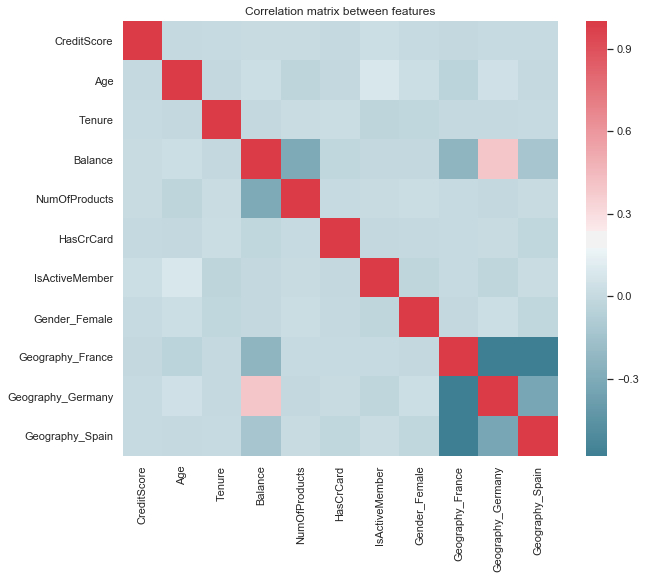

In [315]:
f, ax = plt.subplots(figsize=(10, 8))
plt.title('Correlation matrix between features')
corr = X.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

#### GridSearchCV

GridSearch allows to quickly tune the parameters of a model. In the case of the LogisticRegression classifier, this will include here the `C` parameter and the `penalty`.


- `C`: this parameter regulates the strength of the regularization. Regularization is used in LogisticRegression to penalize large weights and reduce overfitting. Decreasing the parameter `C` increases regularization (typically the parameter `lambda`) and can help to fix a high variance model.
- `penalty`: typically the `l1` (Lasso Regression) or the `l2` (Ridge Regression) regularization method is used with LogisticRegression. In the case of the Ridge Regression, the cost function that the algorithm (i.e. Gradient Descent) is trying to optimize is adjusted by adding a regularization term that penalizes the squared values of the weights. In Lasso Regression, the regularization term penalizes using the absolute values of the weight coefficients. Most notable difference between the two choices is that Lasso Regression shrinks less important features weights to zero which does remove some features all together.

For the scoring in the GridSearchCV, the AUC-ROC curve will be used that is very useful for assessing the performance of a classification model's performance. AUC refers to Area Under The Curve and ROC to Receiver Operating Characteristic. The AUC-ROC curve informs how much the model is able to distinguish between the classes. It does so by comparing the true positive rate and false positive rate for different decision boundaries (thresholds for predicting either of the classes):

- True positive rate (Recall) = $\frac{\textrm{True positives}}{\textrm{True positives}\ +\ \textrm{False negatives}}$
- False positive rate (Recall) = $\frac{\textrm{False positives}}{\textrm{True negatives}\ +\ \textrm{False positives}}$

GridSearchCV with LogisticRegression using score roc_auc and accuracy
Tuned hpyerparameters :(best parameters)  {'C': 215.44346900318823, 'penalty': 'l1'}
Best score (refit key) : 0.8125


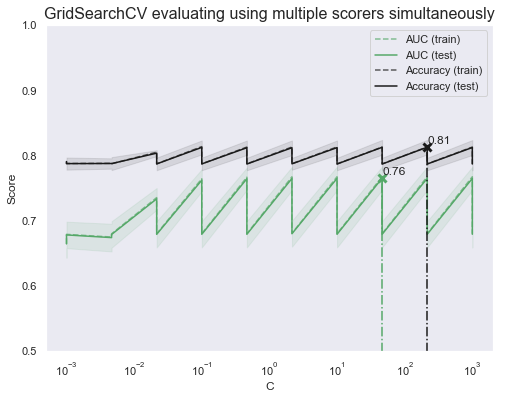

In [316]:
grid_search_figure=True
lr_optimized = Model().MVP_LogisticRegression(X_train, y_train, X_test, y_test, grid_search_figure)

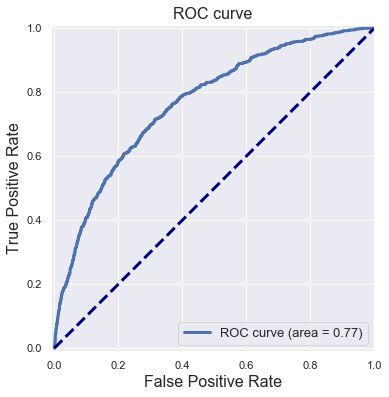

In [349]:
scores = lr_optimized.fit(X_train, y_train).decision_function(X_test)
Model_Plots().plot_roc_curve(X_train, y_train, X_test, y_test, scores)

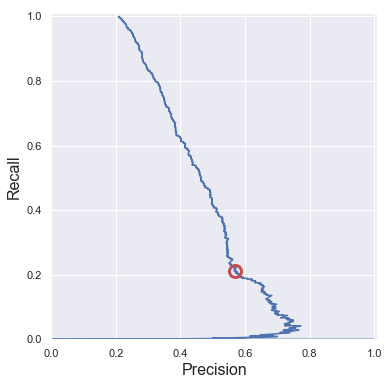

In [350]:
scores = lr_optimized.fit(X_train, y_train).decision_function(X_test)
Model_Plots().plot_prec_rec_curve(X_train, y_train, X_test, y_test, scores)

In [321]:
lr_predicted_test = lr_optimized.predict(X_test)
# Combined report with all above metrics
print(classification_report(y_test, lr_predicted_test, target_names=['Stayed', 'Exited']))

              precision    recall  f1-score   support

      Stayed       0.83      0.96      0.89      3190
      Exited       0.57      0.21      0.31       810

    accuracy                           0.81      4000
   macro avg       0.70      0.58      0.60      4000
weighted avg       0.77      0.81      0.77      4000



It is evident from the plots that this LogisticRegression model performs poorly as it is not better than the dummy model.

### 3.2 DecisionTree

DecisionTrees work like flow charts, where a series of yes/no questions are answered. RandomForests are extensions of DecisionTrees by making predictions using an ensemble of trees and taking the average of the tree. That way, they make use of the power of the crowd. Individual trees are created from a different subset (that can be overlapping but is not identical to any other subset) of the dataset. 



#### Randomized Search and Grid Search

Grid Search is an exhaustive search for selecting a model. In Grid Search, a grid of hyperparameter values is set up and for each combination, a model is trained and scored on the test data. In this approach, every combination of hyperparameter values is tried which can be very inefficient. For example, searching 20 different parameter values for each of 4 parameters will require 160,000 trials of cross-validation. This equates to 1,600,000 model fits and 1,600,000 predictions if 10-fold cross validation is used. While Scikit Learn offers the GridSearchCV function to simplify the process, it would be an extremely costly execution both in computing power and time.


By contrast, Random Search sets up a grid of hyperparameter values and selects random combinations to train the model and score. This allows to explicitly control the number of parameter combinations that are attempted. The number of search iterations is set based on time or resources. Scikit Learn offers the RandomizedSearchCV function for this process.

#### Randomized Search on DecisionTreeClassifier


In [385]:
# Strategy used to choose the split at each node
splitter = ['best', 'random']
# function to measure the quality of a split
criterion = ['gini','entropy']
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 20, 50, 100, 500, 1000]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 5, 6, 7, 10]

# Create the random grid
random_grid = { 
    "splitter": splitter,
    'criterion': criterion,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
}
# Use the random grid to search for best hyperparameters
# First create the base model to tune
dt = DecisionTreeClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
dt_random = RandomizedSearchCV(estimator=dt, param_distributions=random_grid, n_iter=100, cv=10, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
dt_random.fit(X_train, y_train)

print("Best parameters from RandomizedSearch:")
dt_random.best_params_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s


Best parameters from RandomizedSearch:


[Parallel(n_jobs=-1)]: Done 867 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.8s finished


{'splitter': 'best',
 'min_samples_split': 100,
 'min_samples_leaf': 4,
 'max_depth': 20,
 'criterion': 'gini'}

#### Grid Search on DecisionTreeClassifier

In [386]:
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

grid = { 
    "splitter":['best', 'random'],
    'criterion':['gini'],
    'max_depth': [5, 10, 15, 20, 25, 30],
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'min_samples_split': [15, 10, 20, 25, 30],
}


dt = DecisionTreeClassifier()
dt_cv = GridSearchCV(dt, grid, cv=10, scoring=scoring, refit='AUC', return_train_score=True)
dt_cv.fit(X_train, y_train)
results = dt_cv.cv_results_
print("Tuned hpyerparameters :(best parameters) ", dt_cv.best_params_)
print("Best score (refit key) :", dt_cv.best_score_)
dt_optimized = dt_cv.best_estimator_

Tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 20, 'splitter': 'best'}
Best score (refit key) : 0.8368856477978442


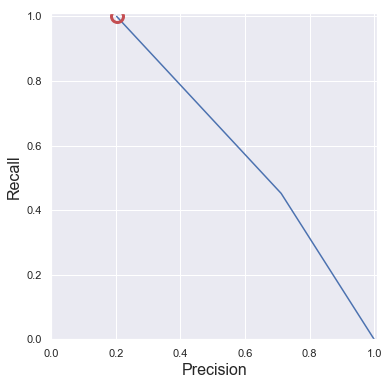

In [389]:
scores = dt_optimized.fit(X_train, y_train).predict(X_test)
Model_Plots().plot_prec_rec_curve(X_train, y_train, X_test, y_test, scores)

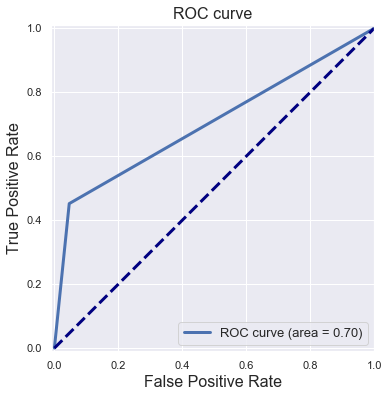

In [390]:
scores = dt_optimized.fit(X_train, y_train).predict(X_test)
Model_Plots().plot_roc_curve(X_train, y_train, X_test, y_test, scores)

In [391]:
dt_predicted_test = dt_optimized.predict(X_test)
# Combined report with all above metrics
print(classification_report(y_test, dt_predicted_test, target_names=['Stayed', 'Exited']))

              precision    recall  f1-score   support

      Stayed       0.87      0.95      0.91      3190
      Exited       0.71      0.45      0.55       810

    accuracy                           0.85      4000
   macro avg       0.79      0.70      0.73      4000
weighted avg       0.84      0.85      0.84      4000



The DecisionTree classifier performed better than the LogisticRegression one. 

### 3.2 DecisionTrees: RandomForest

When the dataset is of medium or large size, one can use a RandomForest to get better results.

#### Random Search on RandomForestClassifier

In [355]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
# Fit the random search model
rf_random.fit(X_train, y_train)
# rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.0min finished


{'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

#### Visualize one DecisionTree from the forest

In [372]:
# visualize one tree, will be saved as png
clf = RandomForestClassifier(
                                        n_estimators=400,
                                        min_samples_split=5,
                                        min_samples_leaf=2,
                                        max_features='auto',
                                        max_depth=None,
                                        bootstrap=True                                 
                                    )
clf.fit(X_train, y_train)
# pick one of the trees
estimator = clf.estimators_[5]
Model_Plots().visualize_decision_tree(estimator, outpath='../05.Insights/')

Exported decision tree to ../05.Insights/tree.png


#### Grid Search on RandomForestClassifier

In [374]:
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [None, 10, 50, 100],
    'max_features': ['auto', 2, 3],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [3, 5, 7],
    'n_estimators': [200, 300, 400, 500, 600, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
rf_cv = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2,  scoring=scoring, refit='AUC', return_train_score=True)
rf_cv.fit(X_train, y_train)
results = rf_cv.cv_results_
print("Tuned hpyerparameters :(best parameters) ", rf_cv.best_params_)
print("Best score (refit key) :", rf_cv.best_score_)
rf_optimized = rf_cv.best_estimator_


Fitting 3 folds for each of 648 candidates, totalling 1944 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 1944 out of 1944 | elapsed: 18.3min finished


Tuned hpyerparameters :(best parameters)  {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best score (refit key) : 0.8615321411136502


In [402]:
print("Classification report for LogisticRegression")
lr_predicted_test = lr_optimized.predict(X_test)
# Combined report with all above metrics
print(classification_report(y_test, lr_predicted_test, target_names=['Stayed', 'Exited']))
print("Classification report for DecisionTreeClassifier")
print(classification_report(y_test, dt_predicted_test, target_names=['Stayed', 'Exited']))
print("Classification report for RandomForestClassifier")
rf_predicted_test = rf_optimized.predict(X_test)
# Combined report with all above metrics
print(classification_report(y_test, rf_predicted_test, target_names=['Stayed', 'Exited']))

Classification report for LogisticRegression
              precision    recall  f1-score   support

      Stayed       0.83      0.96      0.89      3190
      Exited       0.57      0.21      0.31       810

    accuracy                           0.81      4000
   macro avg       0.70      0.58      0.60      4000
weighted avg       0.77      0.81      0.77      4000

Classification report for DecisionTreeClassifier
              precision    recall  f1-score   support

      Stayed       0.87      0.95      0.91      3190
      Exited       0.71      0.45      0.55       810

    accuracy                           0.85      4000
   macro avg       0.79      0.70      0.73      4000
weighted avg       0.84      0.85      0.84      4000

Classification report for RandomForestClassifier
              precision    recall  f1-score   support

      Stayed       0.87      0.97      0.92      3190
      Exited       0.81      0.45      0.58       810

    accuracy                           

The RandomForestClassifier performed slightly better than the DecisionTreeClassifier.

### 3.3 K-NN


The K nearest neighbor classifier uses patterns in the data to place new points in a relevant category. The algorithm analyses the likeness of a new sample point given the traning sample points. It is an intuitive algorithm that does not make assumptions on the data.

#### Random Search with KNN

In [400]:
# Number of neighbors to use by default for kneighbors queries
n_neighbors = np.arange(1,101,1)
# weight function used in prediction
weights = ['uniform', 'distance']
# Power parameter for the Minkowski metric, 1: manhattan_distance, 2: euclidean_distance
p = [1, 2]

param_grid = {
    "n_neighbors": n_neighbors,
    "weights": weights,
    "p": p
}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
knn = KNeighborsClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
knn_random = RandomizedSearchCV(estimator=knn, param_distributions=param_grid, n_iter=100, cv=10, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
knn_random.fit(X_train, y_train)

print("Best parameters from RandomizedSearch:")
knn_random.best_params_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:    2.6s


Best parameters from RandomizedSearch:


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


{'weights': 'uniform', 'p': 1, 'n_neighbors': 20}

#### Grid Search with KNN

In [401]:
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
# Create the parameter grid based on the results of random search 
param_grid = {
    "n_neighbors": n_neighbors,
    "weights": weights,
    "p": p
}
# Create a based model
knn = KNeighborsClassifier()
# Instantiate the grid search model
knn_cv = GridSearchCV(estimator=knn, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2,  scoring=scoring, refit='AUC', return_train_score=True)
knn_cv.fit(X_train, y_train)
results = knn_cv.cv_results_
print("Tuned hpyerparameters :(best parameters) ", knn_cv.best_params_)
print("Best score (refit key) :", knn_cv.best_score_)
knn_optimized = knn_cv.best_estimator_


Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:   34.4s


Tuned hpyerparameters :(best parameters)  {'n_neighbors': 64, 'p': 1, 'weights': 'distance'}
Best score (refit key) : 0.6209764378582255


[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:   48.0s finished


In [403]:
print("Classification report for LogisticRegression")
print(classification_report(y_test, lr_predicted_test, target_names=['Stayed', 'Exited']))

print("Classification report for DecisionTreeClassifier")
print(classification_report(y_test, dt_predicted_test, target_names=['Stayed', 'Exited']))

print("Classification report for RandomForestClassifier")
print(classification_report(y_test, rf_predicted_test, target_names=['Stayed', 'Exited']))

print("Classification report for KNNClassifier")
knn_predicted_test = knn_optimized.predict(X_test)
print(classification_report(y_test, knn_predicted_test, target_names=['Stayed', 'Exited']))

Classification report for LogisticRegression
              precision    recall  f1-score   support

      Stayed       0.83      0.96      0.89      3190
      Exited       0.57      0.21      0.31       810

    accuracy                           0.81      4000
   macro avg       0.70      0.58      0.60      4000
weighted avg       0.77      0.81      0.77      4000

Classification report for DecisionTreeClassifier
              precision    recall  f1-score   support

      Stayed       0.87      0.95      0.91      3190
      Exited       0.71      0.45      0.55       810

    accuracy                           0.85      4000
   macro avg       0.79      0.70      0.73      4000
weighted avg       0.84      0.85      0.84      4000

Classification report for RandomForestClassifier
              precision    recall  f1-score   support

      Stayed       0.87      0.97      0.92      3190
      Exited       0.81      0.45      0.58       810

    accuracy                           

The KNNClassifier does perform very poorly compared to the other algorithms. This is very evident from the f1 score (harmonic mean of recall and precision), for example in the Exited class, where the score is very low.

### 3.4 Naive Bayes

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the strong, “naive” assumption of conditional independence between every pair of features given the value of the class variable. In many datasets, there can be some level of correlation between the independent variables contained within them. It does still work quite well for problems, i.e. E-Mail spam detection.

#### Complement Naive Bayes classifier 

The Complement Naive Bayes classifier was designed to correct the “severe assumptions” made by the standard Multinomial Naive Bayes classifier. It is particularly suited for imbalanced data sets.

In [405]:
from sklearn.naive_bayes import ComplementNB
CNB = ComplementNB()
CNB.fit(X_train, y_train)
CNB_predicted_test = CNB.predict(X_test)
print(classification_report(y_test, CNB_predicted_test, target_names=['Stayed', 'Exited']))

              precision    recall  f1-score   support

      Stayed       0.84      0.45      0.59      3190
      Exited       0.24      0.67      0.35       810

    accuracy                           0.50      4000
   macro avg       0.54      0.56      0.47      4000
weighted avg       0.72      0.50      0.54      4000



#### Gaussian Naive Bayes

In [406]:
from sklearn.naive_bayes import GaussianNB
GCB = GaussianNB()
GCB.fit(X_train, y_train)
GCB_predicted_test = GCB.predict(X_test)
print(classification_report(y_test, GCB_predicted_test, target_names=['Stayed', 'Exited']))

              precision    recall  f1-score   support

      Stayed       0.81      0.97      0.88      3190
      Exited       0.38      0.09      0.14       810

    accuracy                           0.79      4000
   macro avg       0.59      0.53      0.51      4000
weighted avg       0.72      0.79      0.73      4000



#### Bernoulli Naive Bayes

In [407]:
from sklearn.naive_bayes import BernoulliNB
BNB = BernoulliNB()
BNB.fit(X_train, y_train)
BNB_predicted_test = BNB.predict(X_test)
print(classification_report(y_test, BNB_predicted_test, target_names=['Stayed', 'Exited']))

              precision    recall  f1-score   support

      Stayed       0.82      0.94      0.87      3190
      Exited       0.41      0.18      0.25       810

    accuracy                           0.78      4000
   macro avg       0.62      0.56      0.56      4000
weighted avg       0.74      0.78      0.75      4000



These classifiers do not perform better than the baseline classifier. Naive Bayes is still a good classifier for non-linear problems, where the classes cannot be separated easily. Also, it is a very outlier resistant algorithm.

#### Overview

In [413]:
print("Accuracy of dummy model")
print('Training set accuracy: {:.2f}'.format(accuracy_score(y_train, dummy_majority.predict(X_train))))
print('Test set accuracy: {:.2f}'.format(accuracy_score(y_test, dummy_majority.predict(X_test))) + '\n')

print("Classification report for LogisticRegression")
print(classification_report(y_test, lr_predicted_test, target_names=['Stayed', 'Exited']))

print("Classification report for DecisionTreeClassifier")
print(classification_report(y_test, dt_predicted_test, target_names=['Stayed', 'Exited']))

print("Classification report for RandomForestClassifier")
print(classification_report(y_test, rf_predicted_test, target_names=['Stayed', 'Exited']))

print("Classification report for KNNClassifier")
knn_predicted_test = knn_optimized.predict(X_test)
print(classification_report(y_test, knn_predicted_test, target_names=['Stayed', 'Exited']))

Accuracy of dummy model
Training set accuracy: 0.80
Test set accuracy: 0.80

Classification report for LogisticRegression
              precision    recall  f1-score   support

      Stayed       0.83      0.96      0.89      3190
      Exited       0.57      0.21      0.31       810

    accuracy                           0.81      4000
   macro avg       0.70      0.58      0.60      4000
weighted avg       0.77      0.81      0.77      4000

Classification report for DecisionTreeClassifier
              precision    recall  f1-score   support

      Stayed       0.87      0.95      0.91      3190
      Exited       0.71      0.45      0.55       810

    accuracy                           0.85      4000
   macro avg       0.79      0.70      0.73      4000
weighted avg       0.84      0.85      0.84      4000

Classification report for RandomForestClassifier
              precision    recall  f1-score   support

      Stayed       0.87      0.97      0.92      3190
      Exited     

# Summary

In this part, the customer churn was predicted using a very fast MVP. Comparing to the baseline dummy model (80% accuracy predicting majority class), a RandomForest and DecisionTree classifier performed slightly better with an accuracy of 87% and 85%, respectively. A logistic regression classifier did also perform slightly better than the baseline model (81%). KNN and Naive Bayes classifier performed very poorly.

In the next step of the project, the features will be refined, i.e. normalized, scaled, to improve model performance.